# Machine Learning

In this project I will be working towards classifying patient records into two groups predicting if they will die due to COVID-19. To run this please put the latestdata.csv from https://github.com/beoutbreakprepared/nCoV2019/tree/master/latest_data into a folder called latestdata so the directory structure appears as follows:

./chpf93.py
./latestdata/latestdata.csv
    
and then run the notebook sequentially. This will produce a couple of additional CSV files that serve as checkpoints.

Note: some of the cross validations for my experimentation with the models takes a signficant amount of time. These functions are labelled with the time that they took. 

## Data Cleaning

I begin by loading the .csv file into pandas. Pandas is most suitable for this because of the size of the file. low_memory=False prevents pandas warning about the mixed types of the data. 'df' is the standard variable name choice for a data frame.

In [1]:
%matplotlib inline
import pandas as pd
df = pd.read_csv("./latestdata/latestdata.csv", low_memory=False)

Once it has loaded, I look at the head of the .csv to get a brief overview of the data.

In [2]:
df.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,...,NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,...,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,...,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,...,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,...,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


Immediately, it is clear that there is a significant amount of missing data which will need to be cleaned before I can use the data set. Before this, I look at the structure of the columns so I can begin analysis of the data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676311 entries, 0 to 2676310
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ID                        object 
 1   age                       object 
 2   sex                       object 
 3   city                      object 
 4   province                  object 
 5   country                   object 
 6   latitude                  float64
 7   longitude                 float64
 8   geo_resolution            object 
 9   date_onset_symptoms       object 
 10  date_admission_hospital   object 
 11  date_confirmation         object 
 12  symptoms                  object 
 13  lives_in_Wuhan            object 
 14  travel_history_dates      object 
 15  travel_history_location   object 
 16  reported_market_exposure  object 
 17  additional_information    object 
 18  chronic_disease_binary    bool   
 19  chronic_disease           object 
 20  source                  

There is a lot of data to begin processing. I need to analyse the columns further before I can do any meaningful analysis since there is so much data and the data type for most is currently very generic as 'object'. 

In [4]:
df.isna().sum()

ID                                0
age                         2098293
sex                         2096154
city                         977681
province                     452664
country                         115
latitude                         61
longitude                        61
geo_resolution                   61
date_onset_symptoms         2414712
date_admission_hospital     2560100
date_confirmation            108489
symptoms                    2674259
lives_in_Wuhan              2671973
travel_history_dates        2673700
travel_history_location     2667089
reported_market_exposure    2675242
additional_information      2630456
chronic_disease_binary            0
chronic_disease             2676096
source                       566964
sequence_available          2676299
outcome                     2368929
date_death_or_discharge     2673163
notes_for_discussion        2675671
location                    2662935
admin3                      2595877
admin2                      

I first want to look at some generic statistics about the features to begin thinking about the best way to go about cleaning it. Here I plot all of the countries that make up at least 1% of the records (if this condition is not imposed then the bar chart is unreadable)

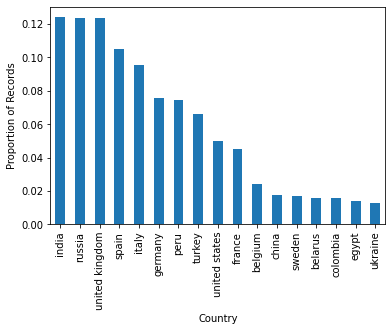

In [5]:
import matplotlib.pyplot as plt

filtered_countries = df[df["country"].map(df["country"].value_counts(normalize=True, dropna=False)) > 0.01]["country"]
filtered_countries.str.lower().value_counts(normalize=True, dropna=False).plot(kind="bar")

plt.xlabel("Country")
plt.ylabel("Proportion of Records")
plt.savefig("country-summary.png")
plt.show()

Since my question is related to predicting the outcome for a specific person I need that the outcome is not N/A. This will drastically reduce the number of records however.

In [6]:
df = df[df["outcome"].notna()]
df.to_csv("with_outcome.csv", index=False)

This has now removed all of the rows without an outcome.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307382 entries, 0 to 673607
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        307382 non-null  object 
 1   age                       34435 non-null   object 
 2   sex                       38115 non-null   object 
 3   city                      263094 non-null  object 
 4   province                  306481 non-null  object 
 5   country                   307380 non-null  object 
 6   latitude                  307382 non-null  float64
 7   longitude                 307382 non-null  float64
 8   geo_resolution            307382 non-null  object 
 9   date_onset_symptoms       3543 non-null    object 
 10  date_admission_hospital   301 non-null     object 
 11  date_confirmation         307308 non-null  object 
 12  symptoms                  476 non-null     object 
 13  lives_in_Wuhan            174 non-null     o

This has drastically reduced the dataset size from ~2.6m to ~307k records. Of course, this is not the most desirable outcome but I cannot impute the outcome data as it will skew any models drastically. One advantage of this is that I will have less records to manage though so the models should train faster which will be useful for experimenting.

Now I look at the summary of the na data points:

In [8]:
df.isna().sum()

ID                               0
age                         272947
sex                         269267
city                         44288
province                       901
country                          2
latitude                         0
longitude                        0
geo_resolution                   0
date_onset_symptoms         303839
date_admission_hospital     307081
date_confirmation               74
symptoms                    306906
lives_in_Wuhan              307208
travel_history_dates        307067
travel_history_location     306414
reported_market_exposure    307366
additional_information      288785
chronic_disease_binary           0
chronic_disease             307257
source                       27687
sequence_available          307378
outcome                          0
date_death_or_discharge     306188
notes_for_discussion        307231
location                    300812
admin3                      307359
admin2                      306873
admin1              

There is quite a significant amount of data missing. Some of the columns will essentially be unrecoverable because of the proportion of missing data. These columns that I have identified immediately are "date_onset_symptoms", "date_admission_hospital", "symptoms", "lives_in_Wuhan", "reported_market_exposure", "sequence_available", "date_death_or_discharge", "notes_for_discussion", "admin3", "admin2" as there is simply too much data missing. So I will drop these columns from the dataset.

In [9]:
df = df.drop(["date_onset_symptoms", "date_admission_hospital","symptoms", "lives_in_Wuhan", "reported_market_exposure",
              "sequence_available", "date_death_or_discharge", "notes_for_discussion", "admin3", "admin2"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307382 entries, 0 to 673607
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       307382 non-null  object 
 1   age                      34435 non-null   object 
 2   sex                      38115 non-null   object 
 3   city                     263094 non-null  object 
 4   province                 306481 non-null  object 
 5   country                  307380 non-null  object 
 6   latitude                 307382 non-null  float64
 7   longitude                307382 non-null  float64
 8   geo_resolution           307382 non-null  object 
 9   date_confirmation        307308 non-null  object 
 10  travel_history_dates     315 non-null     object 
 11  travel_history_location  968 non-null     object 
 12  additional_information   18597 non-null   object 
 13  chronic_disease_binary   307382 non-null  bool   
 14  chro

Now I want to analyse the travel_history_dates and travel_history_location to try and increase the number of records with a travel_history_binary set. To do this I want to look at all of the records that have either travel_history_dates or travel_history_location set and an empty travel_history_binary:

In [10]:
travel_binary_frame = df[(df["travel_history_binary"].isna()) &
                         ((df["travel_history_dates"].notna()) | (df["travel_history_location"].notna()))]
travel_binary_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 43285
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       93 non-null     object 
 1   age                      82 non-null     object 
 2   sex                      89 non-null     object 
 3   city                     80 non-null     object 
 4   province                 73 non-null     object 
 5   country                  93 non-null     object 
 6   latitude                 93 non-null     float64
 7   longitude                93 non-null     float64
 8   geo_resolution           93 non-null     object 
 9   date_confirmation        93 non-null     object 
 10  travel_history_dates     72 non-null     object 
 11  travel_history_location  93 non-null     object 
 12  additional_information   69 non-null     object 
 13  chronic_disease_binary   93 non-null     bool   
 14  chronic_disease          

This leaves 93 records. I want to see the values that are present in the travel_history_location since it is not-null for all of the records here:

In [11]:
unique_travel_locations = travel_binary_frame["travel_history_location"].str.lower().unique()
unique_travel_locations

array(['china', 'wuhan city, hubei', 'milan, lombardia, italy',
       'daegu, south korea', 'jakarta, indonesia',
       'johor, malaysia; singapore',
       'wuhan city, hubei; hong kong, china', 'hubei',
       'haute-savoie, auvergne-rhone-alpes, france',
       'new york city, new york, united states', "xi'an city, shaanxi",
       "xiogan city, hubei; xi'an city, shaanxi", 'weinan city, shaanxi',
       'ankang city, shaanxi', 'south korea', 'shenzhen city, guangdong',
       'nha trang, khanh hoa, vietnam', 'suzhou city, jiangsu',
       'dongguan city, guangdong',
       'tianmen city, hubei; wuhan city, hubei; anhui',
       'guiyang city, guizhou', 'italy', 'ezhou city, hubei', 'france',
       'bavaria, germany', 'thailand', 'malaysia'], dtype=object)

These are all locations (I wanted to check it didn't say that they didn't travel in this column) so I can set all of these records travel_history_binary to True in the main data frame and drop the travel_history_dates and travel_history_location columns.

In [12]:
def clean_travel_binary(row):
    if pd.notna(row["travel_history_binary"]):
        return row["travel_history_binary"]

    if pd.isna(row["travel_history_dates"]) and pd.isna(row["travel_history_location"]):
        return row["travel_history_binary"]

    return True

df["travel_history_binary"] = df.apply(clean_travel_binary, axis=1)
df = df.drop(["travel_history_dates", "travel_history_location"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307382 entries, 0 to 673607
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       307382 non-null  object 
 1   age                      34435 non-null   object 
 2   sex                      38115 non-null   object 
 3   city                     263094 non-null  object 
 4   province                 306481 non-null  object 
 5   country                  307380 non-null  object 
 6   latitude                 307382 non-null  float64
 7   longitude                307382 non-null  float64
 8   geo_resolution           307382 non-null  object 
 9   date_confirmation        307308 non-null  object 
 10  additional_information   18597 non-null   object 
 11  chronic_disease_binary   307382 non-null  bool   
 12  chronic_disease          125 non-null     object 
 13  source                   279695 non-null  object 
 14  outc

The remaining records without a travel_history_binary make up a tiny proportion of the dataset (232 out of 307382 records) so we can drop these as we cannot recover their true value.

In [13]:
df = df[df["travel_history_binary"].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307150 entries, 0 to 673607
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       307150 non-null  object 
 1   age                      34221 non-null   object 
 2   sex                      37947 non-null   object 
 3   city                     262879 non-null  object 
 4   province                 306297 non-null  object 
 5   country                  307149 non-null  object 
 6   latitude                 307150 non-null  float64
 7   longitude                307150 non-null  float64
 8   geo_resolution           307150 non-null  object 
 9   date_confirmation        307115 non-null  object 
 10  additional_information   18463 non-null   object 
 11  chronic_disease_binary   307150 non-null  bool   
 12  chronic_disease          100 non-null     object 
 13  source                   279463 non-null  object 
 14  outc

There still remains quite a bit of redundant information encoded in the data. Namely, location and admin1 are determined by the latitude and longitude which we have for all of the records (whereas location and admin1 are missing for some). I also think that additional_information and data_moderator_initials are metadata about the collation of the data set rather than about the patients instead. This will be easiest to check by looking at a few records that have these values set:

In [14]:
pd.set_option("display.max_columns", None)
df[df["data_moderator_initials"].notna()].head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_confirmation,additional_information,chronic_disease_binary,chronic_disease,source,outcome,location,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
41396,000-1-73,37,male,Gold Coast,Queensland,Australia,-28.01670,153.400000,point,05.02.2020,QLD Case 4 part of the same travel group of pa...,False,NaN,https://twitter.com/allysonhorn/status/1224995...,discharge,Gold Coast,Queensland,Australia,3616.0,SL,True
135171,002-113709,NaN,NaN,NaN,West Bengal,India,23.79776,87.986406,point,27.04.2020,NaN,False,NaN,mohfw.gov.in,Hospitalized,NaN,NaN,India,11129.0,TR,False
135173,002-113710,NaN,NaN,NaN,West Bengal,India,23.79776,87.986406,point,27.04.2020,NaN,False,NaN,mohfw.gov.in,Hospitalized,NaN,NaN,India,11129.0,TR,False
135174,002-113711,NaN,NaN,NaN,West Bengal,India,23.79776,87.986406,point,27.04.2020,NaN,False,NaN,mohfw.gov.in,Hospitalized,NaN,NaN,India,11129.0,TR,False
135175,002-113712,NaN,NaN,NaN,West Bengal,India,23.79776,87.986406,point,27.04.2020,NaN,False,NaN,mohfw.gov.in,Hospitalized,NaN,NaN,India,11129.0,TR,False


In [15]:
df[df["additional_information"].notna()].head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_confirmation,additional_information,chronic_disease_binary,chronic_disease,source,outcome,location,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,14.02.2020,Case 55; mainland China travel via the Lok Ma ...,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,"critical condition, intubated as of 14.02.2020",Shek Lei,Hong Kong,China,8029.0,NaN,True
1113,000-1-110,1,male,KK Women’s and Children’s Hospital,NaN,Singapore,1.310490,103.846761,point,16.02.2020,Case 76; Singapore Citizen who was among the g...,False,NaN,https://bnonews.com/wp-content/uploads/2020/02...,discharge,NaN,NaN,Singapore,10332.0,NaN,True
1446,000-1-113,32,male,National Centre for Infectious Diseases,NaN,Singapore,1.322098,103.847200,point,21.02.2020,"Case 87; Wuhan evacuation, linked to case #76",False,NaN,https://www.moh.gov.sg/news-highlights/details...,discharge,National Centre for Infectious Diseases,NaN,Singapore,6480.0,NaN,True
2112,000-1-119,NaN,female,NaN,Ticino,Switzerland,46.298856,8.808264,admin1,25.02.2020,Infected at an event on t he 15th Feb 2020,False,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,discharge,NaN,Ticino,Switzerland,860.0,NaN,True
2224,000-1-120,22,female,NaN,Jeju,South Korea,33.384640,126.555100,admin1,23.02.2020,Case 222; Jeju Case 2,False,NaN,https://www.jeju.go.kr/corona19.jsp#corona-main,discharge,NaN,Jeju,South Korea,501.0,NaN,True


It is apparent that additional_information and data_moderator_initials are not going to be processable nor useful for machine learning purposes. I will drop all of these columns.

In [16]:
df = df.drop(["location", "admin1", "additional_information", "data_moderator_initials"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307150 entries, 0 to 673607
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      307150 non-null  object 
 1   age                     34221 non-null   object 
 2   sex                     37947 non-null   object 
 3   city                    262879 non-null  object 
 4   province                306297 non-null  object 
 5   country                 307149 non-null  object 
 6   latitude                307150 non-null  float64
 7   longitude               307150 non-null  float64
 8   geo_resolution          307150 non-null  object 
 9   date_confirmation       307115 non-null  object 
 10  chronic_disease_binary  307150 non-null  bool   
 11  chronic_disease         100 non-null     object 
 12  source                  279463 non-null  object 
 13  outcome                 307150 non-null  object 
 14  country_new         

1 record is missing the country so lets look at the record

In [17]:
missing_country = df[df["country"].isna()]
missing_country

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_confirmation,chronic_disease_binary,chronic_disease,source,outcome,country_new,admin_id,travel_history_binary
135606,002-11410,60-69,male,NaN,Taiwan,NaN,23.75947,120.9559,admin1,15.02.2020,True,"hepatitis B, diabetes",https://www.cdc.gov.tw/Bulletin/Detail/C7Sfkry...,death,NaN,846.0,True


It is also missing the country_new field. It is unclear what country to put it under, I will see if there are other records with the province as Taiwan in the dataset.

In [18]:
province_taiwan = df[df["province"].str.lower() == "taiwan"]
province_taiwan

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_confirmation,chronic_disease_binary,chronic_disease,source,outcome,country_new,admin_id,travel_history_binary
135606,002-11410,60-69,male,NaN,Taiwan,NaN,23.75947,120.9559,admin1,15.02.2020,True,"hepatitis B, diabetes",https://www.cdc.gov.tw/Bulletin/Detail/C7Sfkry...,death,NaN,846.0,True


There are none so it would be most appropriate to drop this record as it is only 1 / 307150 records

In [19]:
df = df[df["country"].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307149 entries, 0 to 673607
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      307149 non-null  object 
 1   age                     34220 non-null   object 
 2   sex                     37946 non-null   object 
 3   city                    262879 non-null  object 
 4   province                306296 non-null  object 
 5   country                 307149 non-null  object 
 6   latitude                307149 non-null  float64
 7   longitude               307149 non-null  float64
 8   geo_resolution          307149 non-null  object 
 9   date_confirmation       307114 non-null  object 
 10  chronic_disease_binary  307149 non-null  bool   
 11  chronic_disease         99 non-null      object 
 12  source                  279462 non-null  object 
 13  outcome                 307149 non-null  object 
 14  country_new         

So we have ID, country, latitude, longitude, geo_resolution, chronic_disease_binary, outcome, admin_id, travel_history_binary for all of the records. Next I want to look at the country_new and see if it differs from the country:

In [20]:
differing_countries = df[df["country_new"].notna()]
differing_countries = differing_countries[differing_countries["country"].str.lower() 
                                          != differing_countries["country_new"].str.lower()]
differing_countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      0 non-null      object 
 1   age                     0 non-null      object 
 2   sex                     0 non-null      object 
 3   city                    0 non-null      object 
 4   province                0 non-null      object 
 5   country                 0 non-null      object 
 6   latitude                0 non-null      float64
 7   longitude               0 non-null      float64
 8   geo_resolution          0 non-null      object 
 9   date_confirmation       0 non-null      object 
 10  chronic_disease_binary  0 non-null      bool   
 11  chronic_disease         0 non-null      object 
 12  source                  0 non-null      object 
 13  outcome                 0 non-null      object 
 14  country_new             0 non-null      object 
 15  a

If we exclude non-NA country_new then we have 0 records when looking for differences so we can safely drop the country_new feature as it is redundant

In [21]:
df = df.drop("country_new", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307149 entries, 0 to 673607
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      307149 non-null  object 
 1   age                     34220 non-null   object 
 2   sex                     37946 non-null   object 
 3   city                    262879 non-null  object 
 4   province                306296 non-null  object 
 5   country                 307149 non-null  object 
 6   latitude                307149 non-null  float64
 7   longitude               307149 non-null  float64
 8   geo_resolution          307149 non-null  object 
 9   date_confirmation       307114 non-null  object 
 10  chronic_disease_binary  307149 non-null  bool   
 11  chronic_disease         99 non-null      object 
 12  source                  279462 non-null  object 
 13  outcome                 307149 non-null  object 
 14  admin_id            

Then I look at the distribution of the chronic_disease_binary

In [22]:
df["chronic_disease_binary"].value_counts(dropna=False)

False    307048
True        101
Name: chronic_disease_binary, dtype: int64

Then I see if I can do anything with the free text chronic_disease

In [23]:
chronic_diseases = df["chronic_disease"].str.lower().unique()
len(chronic_diseases)

49

In [24]:
chronic_diseases

array([nan, 'hypertension', 'diabetes, hypertension',
       '"thought to have had other pre-existing conditions"',
       'history of hypertension, type 2 diabetes, coronary heart disease for which a stent had been implanted, and lung cancer',
       'prostate hypertrophy', 'chronic pulmonary condition',
       'hiv positive', 'diabetes', 'hypertension:diabetes',
       'chronic kidney disease:hypertension:diabetes', 'asthma:diabetes',
       'asthma', 'hypertension:diabetes:valvular heart disease',
       'chronic kidney disease', 'hypertensive',
       'diabetes:hypertension:chronic kidney disease',
       'diabetes:hypertenstion:upper git bleeding',
       'diabetes:hypertension', 'chronic kidney disease:hypertension',
       'pre-renal azotemia:cardiomyopathy:hypertension:diabetes',
       'hypertension:diabetes:asthma', 'hypertension:colon cancer',
       'chronic kidney disease:hypertension:diabetes:ischemic heart disease',
       'pre-renal azotemia:diabetes:hypertension',
    

The data looks useful but it will be difficult to categorise and is likely to lead to overfitting as if we introduce a lot of categories then very few records will have a chronic disease assigned to them. Using the binary still risks this overfitting but it shouldn't be as impactful. So I will use these to set all of those with a chronic_disease free text to set the chronic_disease_binary to True if it is missing from a row. (clarify this) since all of the ones above are chronic diseases

In [25]:
def clean_chronic_binary(row):
    if pd.notna(row["chronic_disease_binary"]):
        return row["chronic_disease_binary"]

    # If one of the columns has something then we can set it to true otherwise we don't know
    return pd.notna(row["chronic_disease_binary"])

df["chronic_disease_binary"] = df.apply(clean_chronic_binary, axis=1)
df["chronic_disease_binary"].value_counts(dropna=False)

False    307048
True        101
Name: chronic_disease_binary, dtype: int64

Then we can also drop the chronic_disease feature

In [26]:
df = df.drop(["chronic_disease"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307149 entries, 0 to 673607
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      307149 non-null  object 
 1   age                     34220 non-null   object 
 2   sex                     37946 non-null   object 
 3   city                    262879 non-null  object 
 4   province                306296 non-null  object 
 5   country                 307149 non-null  object 
 6   latitude                307149 non-null  float64
 7   longitude               307149 non-null  float64
 8   geo_resolution          307149 non-null  object 
 9   date_confirmation       307114 non-null  object 
 10  chronic_disease_binary  307149 non-null  bool   
 11  source                  279462 non-null  object 
 12  outcome                 307149 non-null  object 
 13  admin_id                307149 non-null  float64
 14  travel_history_binar

Next I want to look at the date_confirmation field as there is a tiny amount of records missing this. So it is safe to drop any record that does not have this set.

In [27]:
df = df[df["date_confirmation"].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307114 entries, 0 to 673607
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      307114 non-null  object 
 1   age                     34188 non-null   object 
 2   sex                     37914 non-null   object 
 3   city                    262845 non-null  object 
 4   province                306265 non-null  object 
 5   country                 307114 non-null  object 
 6   latitude                307114 non-null  float64
 7   longitude               307114 non-null  float64
 8   geo_resolution          307114 non-null  object 
 9   date_confirmation       307114 non-null  object 
 10  chronic_disease_binary  307114 non-null  bool   
 11  source                  279429 non-null  object 
 12  outcome                 307114 non-null  object 
 13  admin_id                307114 non-null  float64
 14  travel_history_binar

Now I want to convert the travel_history_binary to a boolean and rename some columns to clarify the meaning of their boolean status

In [28]:
df["travel_history_binary"].value_counts(dropna=False)

False    305923
True       1191
Name: travel_history_binary, dtype: int64

It is clearly ready to be made into a boolean field

In [29]:
df = df.rename(columns = { "chronic_disease_binary": "has_chronic_disease", "travel_history_binary": "has_travel_history" })
df["has_travel_history"] = df["has_travel_history"].astype("bool")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307114 entries, 0 to 673607
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   307114 non-null  object 
 1   age                  34188 non-null   object 
 2   sex                  37914 non-null   object 
 3   city                 262845 non-null  object 
 4   province             306265 non-null  object 
 5   country              307114 non-null  object 
 6   latitude             307114 non-null  float64
 7   longitude            307114 non-null  float64
 8   geo_resolution       307114 non-null  object 
 9   date_confirmation    307114 non-null  object 
 10  has_chronic_disease  307114 non-null  bool   
 11  source               279429 non-null  object 
 12  outcome              307114 non-null  object 
 13  admin_id             307114 non-null  float64
 14  has_travel_history   307114 non-null  bool   
dtypes: bool(2), float

Few records are missing the province. I will want to convert the province to categories as well, here I look at the distribution of the provinces:

In [30]:
df["province"].str.lower().value_counts(dropna=False)

maharashtra     106515
tamil nadu       35939
delhi            29173
gujarat          28613
rajasthan        14971
                 ...  
rivers               1
tizi ouzou           1
palawan              1
ticino               1
heilongjiang         1
Name: province, Length: 212, dtype: int64

I will need to use one-hot encoding here because if I just label the categories with numbers then it could lead to the machine learning algorithms thinking that, for example, Delhi > Gujarat whereas this has no meaning in the context. However, one-hot encoding will introduce a large number of additional features which could be an issue as it will impact the training time of the models especially if there are many records. First, I need to see how many values are actually significant.

In [31]:
df["province"].str.lower().value_counts(dropna=False, normalize=True).to_csv("provinces.csv")

Cutting off the provinces for all classes with <1% of the share will leave 28 classes (and an extra one to bundle all the others together but this doesn't need to be a feature since if all the other class features are False then that implies it must be in the bundled class)

In [32]:
def reduce_categories(row, column_name, value_counts, keep_condition, replacement="other"):
    if pd.isna(row[column_name]):
        return replacement
    
    if keep_condition(value_counts[row[column_name].lower()]):
        return row[column_name].lower()

    return replacement

In [33]:
normalised_province_vc = df["province"].str.lower().value_counts(normalize=True) >= 0.01
province_reducer = lambda row: reduce_categories(row, "province", normalised_province_vc, lambda b: b == True)
df["province"] = df.apply(province_reducer, axis=1)
df["province"].value_counts(normalize=True, dropna=False)

maharashtra          0.346826
tamil nadu           0.117022
delhi                0.094991
gujarat              0.093167
rajasthan            0.048747
uttar pradesh        0.043642
madhya pradesh       0.043150
other                0.036996
west bengal          0.030803
andhra pradesh       0.021679
bihar                0.019752
state unassigned     0.018332
karnataka            0.014975
punjab               0.013982
telangana            0.013122
jammu and kashmir    0.011185
odisha               0.010853
haryana              0.010625
metro manila         0.010153
Name: province, dtype: float64

Now I can one-hot encode the categories and remove the original column

In [34]:
province_dummies = pd.get_dummies(df["province"].str.lower(), prefix="province", drop_first=True)
df = pd.concat([df, province_dummies], axis=1)
df = df.drop("province", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307114 entries, 0 to 673607
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID                          307114 non-null  object 
 1   age                         34188 non-null   object 
 2   sex                         37914 non-null   object 
 3   city                        262845 non-null  object 
 4   country                     307114 non-null  object 
 5   latitude                    307114 non-null  float64
 6   longitude                   307114 non-null  float64
 7   geo_resolution              307114 non-null  object 
 8   date_confirmation           307114 non-null  object 
 9   has_chronic_disease         307114 non-null  bool   
 10  source                      279429 non-null  object 
 11  outcome                     307114 non-null  object 
 12  admin_id                    307114 non-null  float64
 13  has_travel_his

I want to do the same now for cities

In [35]:
df["city"].str.lower().value_counts(dropna=False)

mumbai       56178
NaN          44269
chennai      23907
ahmedabad    20815
thane        13085
             ...  
bustos           1
kadwa            1
jiyaguda         1
dharmadam        1
vedigadla        1
Name: city, Length: 2269, dtype: int64

There are a lot of cities so I need to reduce this a lot. I will map the NaN values to other immediately.

In [36]:
df["city"] = df["city"].fillna("other")
df["city"] = df["city"].str.lower().replace({ "unassigned": "other" })
df["city"].str.lower().value_counts(dropna=False, normalize=True).to_csv("cities.csv")

I will use the same condition that I will bundle all of those with <1% of the share of the records

In [37]:
normalised_city_vc = df["city"].str.lower().value_counts(normalize=True) >= 0.01
city_reducer = lambda row: reduce_categories(row, "city", normalised_city_vc, lambda b: b == True)
df["city"] = df.apply(city_reducer, axis=1)
df["city"].value_counts(normalize=True, dropna=False)

other        0.552407
mumbai       0.182922
chennai      0.077844
ahmedabad    0.067776
thane        0.042606
pune         0.037074
indore       0.017655
jaipur       0.011491
kolkata      0.010224
Name: city, dtype: float64

Now I one-hot encode this feature and drop the original column

In [38]:
city_dummies = pd.get_dummies(df["city"].str.lower(), prefix="city", drop_first=True)
df = pd.concat([df, city_dummies], axis=1)
df = df.drop("city", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307114 entries, 0 to 673607
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID                          307114 non-null  object 
 1   age                         34188 non-null   object 
 2   sex                         37914 non-null   object 
 3   country                     307114 non-null  object 
 4   latitude                    307114 non-null  float64
 5   longitude                   307114 non-null  float64
 6   geo_resolution              307114 non-null  object 
 7   date_confirmation           307114 non-null  object 
 8   has_chronic_disease         307114 non-null  bool   
 9   source                      279429 non-null  object 
 10  outcome                     307114 non-null  object 
 11  admin_id                    307114 non-null  float64
 12  has_travel_history          307114 non-null  bool   
 13  province_bihar

Now I need to do something similar to the source column too but first I need to parse the values to simplify them.

In [39]:
copy_df = df

In [40]:
df["source"] = df["source"].fillna("other")
df["source"].value_counts(dropna=False, normalize=True)

other                                                                                                    0.090146
https://arogya.maharashtra.gov.in/pdf/ncovidepressnotemay29.pdf                                          0.036368
https://phdmah.maps.arcgis.com/apps/opsdashboard/index.html#/2cc0055832264c5296890745e9ea415c            0.017323
mohfw.gov.in                                                                                             0.016867
PH Data Drop                                                                                             0.014203
                                                                                                           ...   
http://wsjk.gansu.gov.cn/single/10910/83181.html (b) http://wsjk.gansu.gov.cn/single/10910/83839.html    0.000003
http://www.gov.sz/images/CORONA/ESWATINI-_COVID-19-SITREP-11-1.pdf                                       0.000003
https://twitter.com/ANI/status/1258723708404994049                                      

In [41]:
from urllib.parse import urlsplit

def simplify_sources(row):
    lowercase_url = row["source"].lower()
    
    # Only interested in URLs
    if lowercase_url == "other":
        return "other"

    # Get the website part of the URL
    netloc = urlsplit(lowercase_url).netloc

    if netloc == "":
        return "other"

    return netloc

df["source"] = df.apply(simplify_sources, axis=1)
df["source"].value_counts(dropna=False, normalize=True)

twitter.com                  0.438375
t.me                         0.141351
other                        0.122485
stopcorona.tn.gov.in         0.111773
arogya.maharashtra.gov.in    0.073601
                               ...   
www.ge.ch                    0.000003
www.nytimes.com              0.000003
www.businessinsider.com      0.000003
www.bfmtv.com                0.000003
www.sahealth.sa.gov.au       0.000003
Name: source, Length: 202, dtype: float64

In [42]:
df["source"].str.lower().value_counts(dropna=False, normalize=True).to_csv("sources.csv")

Again, I will apply the >= 1% condition

In [43]:
normalised_source_vc = df["source"].str.lower().value_counts(normalize=True) >= 0.01
source_reducer = lambda row: reduce_categories(row, "source", normalised_source_vc, lambda b: b == True)
df["source"] = df.apply(source_reducer, axis=1)
df["source"].value_counts(normalize=True, dropna=False)

twitter.com                  0.438375
other                        0.160953
t.me                         0.141351
stopcorona.tn.gov.in         0.111773
arogya.maharashtra.gov.in    0.073601
www.wbhealth.gov.in          0.020556
phdmah.maps.arcgis.com       0.017323
www.deshgujarat.com          0.014079
experience.arcgis.com        0.011943
gujcovid19.gujarat.gov.in    0.010045
Name: source, dtype: float64

In [44]:
source_dummies = pd.get_dummies(df["source"].str.lower(), prefix="source", drop_first=True)
df = pd.concat([df, source_dummies], axis=1)
df = df.drop("source", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307114 entries, 0 to 673607
Data columns (total 47 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                307114 non-null  object 
 1   age                               34188 non-null   object 
 2   sex                               37914 non-null   object 
 3   country                           307114 non-null  object 
 4   latitude                          307114 non-null  float64
 5   longitude                         307114 non-null  float64
 6   geo_resolution                    307114 non-null  object 
 7   date_confirmation                 307114 non-null  object 
 8   has_chronic_disease               307114 non-null  bool   
 9   outcome                           307114 non-null  object 
 10  admin_id                          307114 non-null  float64
 11  has_travel_history                307114 non-null  b

Next, I drop some redundant columns that are already covered by the longitude and latitude.


In [45]:
df = df.drop(["geo_resolution", "admin_id"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307114 entries, 0 to 673607
Data columns (total 45 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                307114 non-null  object 
 1   age                               34188 non-null   object 
 2   sex                               37914 non-null   object 
 3   country                           307114 non-null  object 
 4   latitude                          307114 non-null  float64
 5   longitude                         307114 non-null  float64
 6   date_confirmation                 307114 non-null  object 
 7   has_chronic_disease               307114 non-null  bool   
 8   outcome                           307114 non-null  object 
 9   has_travel_history                307114 non-null  bool   
 10  province_bihar                    307114 non-null  uint8  
 11  province_delhi                    307114 non-null  u

Next, I map the countries to categories too

In [46]:
copy_df = df.copy()
df = copy_df

In [47]:
df["country"].value_counts(dropna=False, normalize=True)

India                       0.980525
Philippines                 0.014666
Ghana                       0.001231
Nigeria                     0.000837
China                       0.000440
Paraguay                    0.000410
Ethiopia                    0.000397
Cameroon                    0.000254
Singapore                   0.000238
United States               0.000088
Vietnam                     0.000085
Zambia                      0.000072
Australia                   0.000062
South Korea                 0.000059
Kenya                       0.000049
Niger                       0.000049
Togo                        0.000046
Japan                       0.000039
Tanzania                    0.000033
Algeria                     0.000029
Eswatini                    0.000029
Guinea                      0.000026
Romania                     0.000026
Mozambique                  0.000023
Zimbabwe                    0.000023
Eritrea                     0.000020
Gambia                      0.000020
G

It is almost entirely cases from India so it makes sense to split the data into India and non-India cases.

In [48]:
import numpy as np

df["is_india"] = np.where(df["country"].str.lower() == "india", True, False)
df = df.drop("country", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307114 entries, 0 to 673607
Data columns (total 45 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                307114 non-null  object 
 1   age                               34188 non-null   object 
 2   sex                               37914 non-null   object 
 3   latitude                          307114 non-null  float64
 4   longitude                         307114 non-null  float64
 5   date_confirmation                 307114 non-null  object 
 6   has_chronic_disease               307114 non-null  bool   
 7   outcome                           307114 non-null  object 
 8   has_travel_history                307114 non-null  bool   
 9   province_bihar                    307114 non-null  uint8  
 10  province_delhi                    307114 non-null  uint8  
 11  province_gujarat                  307114 non-null  u

Now I need to convert the outcomes.

In [49]:
# Have to use different syntax here because of a warning raised by pandas
# Source: https://stackoverflow.com/questions/42750551/converting-strings-to-a-lower-case-in-pandas
df.loc[:, "outcome"] = df.loc[:, "outcome"].str.lower()
df["outcome"].unique()

array(['critical condition, intubated as of 14.02.2020', 'discharge',
       'discharged', 'death', 'recovered', 'released from quarantine',
       'stable', 'died',
       'symptoms only improved with cough. currently hospitalized for follow-up.',
       'alive', 'dead', 'deceased', 'stable condition', 'under treatment',
       'critical condition', 'receiving treatment', 'severe illness',
       'unstable', 'hospitalized',
       'treated in an intensive care unit (14.02.2020)', 'severe',
       'migrated', 'migrated_other',
       'https://www.mspbs.gov.py/covid-19.php',
       'discharged from hospital', 'not hospitalized',
       'recovering at home 03.03.2020'], dtype=object)

In [50]:
df["outcome"].value_counts()

hospitalized                                                                202475
recovered                                                                    97313
deceased                                                                      5010
died                                                                           857
under treatment                                                                370
receiving treatment                                                            257
alive                                                                          186
stable condition                                                               133
https://www.mspbs.gov.py/covid-19.php                                          126
discharge                                                                      121
stable                                                                          96
discharged                                                                      90
deat

There is one value that gives no information and that is 'https://www.mspbs.gov.py/covid-19.php'

In [51]:
df = df[df["outcome"] != "https://www.mspbs.gov.py/covid-19.php"]

In [52]:
df["outcome"].value_counts()

hospitalized                                                                202475
recovered                                                                    97313
deceased                                                                      5010
died                                                                           857
under treatment                                                                370
receiving treatment                                                            257
alive                                                                          186
stable condition                                                               133
discharge                                                                      121
stable                                                                          96
discharged                                                                      90
death                                                                           35
dead

As it is unclear from the data set, I assume that hospitialized means that they were hospitalized but ultimately survived. This matches up with the expected death rate of COVID-19 and supports this idea.

In [53]:
copy_df = df.copy()

In [54]:
df = copy_df.copy()

In [55]:
survive_map = {
    "critical condition, intubated as of 14.02.2020": True,
    "discharge": True,
    "discharged": True,
    'death': False,
    'recovered': True,
    'released from quarantine': True,
    'stable': True,
    'died': False,
    'symptoms only improved with cough. currently hospitalized for follow-up.': True,
    'alive': True,
    'dead': False,
    'deceased': False,
    'stable condition': True,
    'under treatment': True,
    'critical condition': True,
    'receiving treatment': True,
    'severe illness': True,
    'unstable': True,
    'hospitalized': True,
    'treated in an intensive care unit (14.02.2020)': True,
    'severe': True,
    'migrated': True,
    'migrated_other': True,
    'discharged from hospital': True,
    'not hospitalized': True,
    'recovering at home 03.03.2020': True
}

df["has_survived"] = df["outcome"].map(survive_map)
df["has_survived"].value_counts(dropna=False, normalize=True)

True     0.980726
False    0.019274
Name: has_survived, dtype: float64

In [56]:
df = df.drop("outcome", axis=1)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306988 entries, 0 to 673607
Data columns (total 45 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                306988 non-null  object 
 1   age                               34188 non-null   object 
 2   sex                               37914 non-null   object 
 3   latitude                          306988 non-null  float64
 4   longitude                         306988 non-null  float64
 5   date_confirmation                 306988 non-null  object 
 6   has_chronic_disease               306988 non-null  bool   
 7   has_travel_history                306988 non-null  bool   
 8   province_bihar                    306988 non-null  uint8  
 9   province_delhi                    306988 non-null  uint8  
 10  province_gujarat                  306988 non-null  uint8  
 11  province_haryana                  306988 non-null  u

Now I will map the date_confirmation feature to a datetime type with an ordinal ordering

In [58]:
import datetime as dt
df["date_confirmation"] = pd.to_datetime(df["date_confirmation"], format="%d.%m.%Y").map(dt.datetime.toordinal)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306988 entries, 0 to 673607
Data columns (total 45 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                306988 non-null  object 
 1   age                               34188 non-null   object 
 2   sex                               37914 non-null   object 
 3   latitude                          306988 non-null  float64
 4   longitude                         306988 non-null  float64
 5   date_confirmation                 306988 non-null  int64  
 6   has_chronic_disease               306988 non-null  bool   
 7   has_travel_history                306988 non-null  bool   
 8   province_bihar                    306988 non-null  uint8  
 9   province_delhi                    306988 non-null  uint8  
 10  province_gujarat                  306988 non-null  uint8  
 11  province_haryana                  306988 non-null  u

This leaves age and sex to resolve. I want to put the age into categories such as 0-9, 10-19, 20-29, ..., 80+. This is an ordinal ordering. However, I also have a major issue in that very few rows containing age and sex. I look at precisely how many records that will be:

In [59]:
age_and_sex_records = df[(df["age"].notna()) & (df["sex"].notna())]
age_and_sex_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33401 entries, 1113 to 673607
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                33401 non-null  object 
 1   age                               33401 non-null  object 
 2   sex                               33401 non-null  object 
 3   latitude                          33401 non-null  float64
 4   longitude                         33401 non-null  float64
 5   date_confirmation                 33401 non-null  int64  
 6   has_chronic_disease               33401 non-null  bool   
 7   has_travel_history                33401 non-null  bool   
 8   province_bihar                    33401 non-null  uint8  
 9   province_delhi                    33401 non-null  uint8  
 10  province_gujarat                  33401 non-null  uint8  
 11  province_haryana                  33401 non-null  uint8  
 12  

In [60]:
copy_df = df.copy()

This reduces the dataset to ~10% of what we had. But unfortunately this data is quite important and is a limitation of the data set.

In [61]:
df = df[(df["age"].notna()) & (df["sex"].notna())]
df["sex"].value_counts(dropna=False)

male      21287
female    12114
Name: sex, dtype: int64

All of the values are non-null and it clearly could be represented as a boolean

In [62]:
df["is_male"] = np.where(df["sex"].str.lower() == "male", True, False)
df = df.drop("sex", axis=1)
df["is_male"].value_counts(dropna=False)

True     21287
False    12114
Name: is_male, dtype: int64

This finally leaves age to clean

In [63]:
df["age"].unique()

array(['1', '32', '22', '68', '44', '39', '46', '27', '40', '30', '66',
       '50-59', '42', '38', '7', '60', '63', '80-89', '33', '79', '9',
       '31', '20-29', '52', '50', '47', '65', '21', '23', '45', '25', '4',
       '40-49', '61', '29', '55', '28', '49', '56', '73', '8', '16', '37',
       '53', '2', '34', '36', '51', '57', '62', '20', '69', '54', '41',
       '43', '74', '78', '75', '59', '18', '15', '24', '17', '19', '14',
       '26', '84', '70', '77', '85', '35', '71', '48', '0.75', '76', '13',
       '11', '91', '67', '82', '72', '64', '90', '0', '81', '58', '80',
       '83', '6', '3', '99', '87', '10', '89', '0.25', '70-79', '12',
       '95', '86', '88', '96', '28-35', '92', '5', '1.5', '0.4', '0.3',
       '98', '94', '2.5', '0.2', '0.7', '29.6', '0.1', '3.5', '0.5', '93',
       '0.9', '54.9', '97', '0.6', '101', '90-99', '60-69', '80-'],
      dtype=object)

So there are fractional ages as well as ranges. First, I convert them all to single integers

In [64]:
import math

def fix_age_ranges_and_fractions(row):
    # Only want those that aren't null
    if pd.isna(row["age"]):
        return row["age"]

    str_age = str(row["age"])
    int_age = -1

    if "-" in str_age:
        splits = str_age.split("-")

        # Deals with those with categories already
        if len(splits) == 1:
            int_age = int(float(splits[0]))
        else:
            str_lower, str_upper = splits
            if str_upper != "":
                int_age = (int(float(splits[0])) + int(float(splits[1]))) // 2
            else:
                int_age = int(float(splits[0]))
    else:
        # Floor the age if someone is 18.9 years we say they are 18 years not 19
        int_age = math.floor(float(str_age))

    return int_age

# Apply the function
df["age"].value_counts(normalize=True)
df["age"] = df.apply(fix_age_ranges_and_fractions, axis=1)

In [65]:
df["age"].value_counts(normalize=True)

30     0.033712
25     0.028113
32     0.027604
35     0.027544
40     0.027275
         ...   
98     0.000060
96     0.000060
93     0.000060
99     0.000060
101    0.000030
Name: age, Length: 101, dtype: float64

Now I map them to categories instead

In [66]:
def map_age_categories(row):
    age = row["age"]
    numeric_ord_map = age // 10
    
    if numeric_ord_map > 8:
        return 8
    
    return numeric_ord_map

df["age_category"] = df.apply(map_age_categories, axis=1)
df["age_category"].value_counts(dropna=False)

2    7599
3    7515
4    5636
5    4323
1    2729
6    2630
0    1409
7    1154
8     406
Name: age_category, dtype: int64

In [67]:
df = df.drop("age", axis=1)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33401 entries, 1113 to 673607
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                33401 non-null  object 
 1   latitude                          33401 non-null  float64
 2   longitude                         33401 non-null  float64
 3   date_confirmation                 33401 non-null  int64  
 4   has_chronic_disease               33401 non-null  bool   
 5   has_travel_history                33401 non-null  bool   
 6   province_bihar                    33401 non-null  uint8  
 7   province_delhi                    33401 non-null  uint8  
 8   province_gujarat                  33401 non-null  uint8  
 9   province_haryana                  33401 non-null  uint8  
 10  province_jammu and kashmir        33401 non-null  uint8  
 11  province_karnataka                33401 non-null  uint8  
 12  

Finally, I remove the ID and save this to a CSV. This will form the dataset for the models.

In [69]:
df = df.drop("ID", axis=1)
df.to_csv("cleaned_dataset.csv", index=False)

## Machine Learning

Now all of the data has been cleaned sufficiently I can begin making predictions.

In [70]:
df = pd.read_csv("cleaned_dataset.csv", low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33401 entries, 0 to 33400
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   latitude                          33401 non-null  float64
 1   longitude                         33401 non-null  float64
 2   date_confirmation                 33401 non-null  int64  
 3   has_chronic_disease               33401 non-null  bool   
 4   has_travel_history                33401 non-null  bool   
 5   province_bihar                    33401 non-null  int64  
 6   province_delhi                    33401 non-null  int64  
 7   province_gujarat                  33401 non-null  int64  
 8   province_haryana                  33401 non-null  int64  
 9   province_jammu and kashmir        33401 non-null  int64  
 10  province_karnataka                33401 non-null  int64  
 11  province_madhya pradesh           33401 non-null  int64  
 12  prov

I first look at the class size to check how imbalanced it is

In [71]:
df["has_survived"].value_counts(dropna=False, normalize=True)

True     0.961319
False    0.038681
Name: has_survived, dtype: float64

I construct a function which will compute some important statistics related to the quality of the predictive model. This allows a standardised comparison of the models. 

In [72]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, matthews_corrcoef, balanced_accuracy_score, f1_score, roc_auc_score, make_scorer

def model_metrics(test_labels, model_predictions):
    cmatrix = confusion_matrix(test_labels, model_predictions)
    tn, fp, fn, tp = cmatrix.ravel()

    print("Test Samples", len(test_labels))
    print("True Positives", tp)
    print("False Positives", fp)
    print("True Negatives", tn)
    print("False Negatives", fn)
    print()

    rs = recall_score(test_labels, model_predictions)
    print("Recall", rs)

    ps = precision_score(test_labels, model_predictions)
    print("Precision", ps)

    mcc = matthews_corrcoef(test_labels, model_predictions)
    print("MCC", mcc)

    bas = balanced_accuracy_score(test_labels, model_predictions, adjusted=True)
    print("BAS", bas)

    f1 = f1_score(test_labels, model_predictions)
    print("F1", f1)
    
    print()
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    tnr = tn / (tn + fp)
    fnr = fn / (tp + fn)
    fdr = fp / (tp + fp)
    
    print("True Positive Rate (Sens / Recall)", tpr)
    print("False Positive Rate (Spec)", fpr)
    print("Positive Predictive Value (PPV / Precision)", ppv)
    print("Negative Predictive Value (NPV)", npv)
    print("True Negative Rate", tnr)
    print("False Negative Rate", fnr)
    print("False Discovery Rate", fdr)
    print()
    
    ber = 0.5 * (fnr + fpr)
    utility = 1 - ber
    
    print("BER", ber)
    print("Utility", utility)
    print()

And I may also want to plot the ROC curves so I import the libraries needed
    

In [73]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

%matplotlib inline

I need to split the data into a training set and a test set as well. I use a 70-30 split and shuffle the instances so that the outcomes are randomly distributed through the set. The random_state is set so that I was able to get reproducible results.

In [74]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, shuffle=True, random_state=1828)

training_unlabelled = train.drop("has_survived", axis=1)
training_labels = train["has_survived"].copy()

test_unlabelled = test.drop("has_survived", axis=1)
test_labels = test["has_survived"].copy()

The data for most of these algorithms will need to be scaled:

In [75]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss_training_unlabelled = ss.fit_transform(training_unlabelled)
ss_test_unlabelled = ss.transform(test_unlabelled)

I start with a SVM model. I use a grid search to test a variety of the parameters. In my experimentation I changed the scaling and scorers. Here, I have it preset to the optimal values that I used in my report. Values may differ due to the stochastic nature of some of the models.

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# Took ~2 hours minutes on an i7-9700K@4.7GHz with 8 concurrent threads
def svm_cross_validation_grid_search(training_unlabelled, training_labels):
    cv_params = {
        "C": [0.01, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1, "scale"],
        "class_weight": [None, "balanced"],
        "kernel": ["sigmoid", "rbf", "linear"]
    }
    
    gs = GridSearchCV(svm.SVC(), cv_params, refit=True, verbose=2, n_jobs=-1, scoring=make_scorer(matthews_corrcoef))
    gs_result = gs.fit(training_unlabelled, training_labels)
    
    print("Best Estimator")
    print(gs_result.best_estimator_)
    print()
    
    print("Best Score")
    print(gs_result.best_score_)
    print()
    
    print("Best Params")
    print(gs_result.best_params_)
    print()

svm_cross_validation_grid_search(ss_training_unlabelled, training_labels)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 114.4min finished


Best Estimator
SVC(C=10, gamma=0.1)

Best Score
0.46135141586703654

Best Params
{'C': 10, 'class_weight': None, 'gamma': 0.1, 'kernel': 'rbf'}



The next function trains and tests the model with the parameters found from the grid search. It also shows the important statistics.

SVM class_weight=None, C=10, gamma=0.1, kernel="rbf"
Training model
Trained model

Predicting
Predicted

Train Score 0.9726261762189906
Test Score 0.9708611914978545
Overfit 0.0017649847211360647

Test Samples 10021
True Positives 9608
False Positives 266
True Negatives 121
False Negatives 26

Recall 0.9973012248287316
Precision 0.973060563094997
MCC 0.4967787872346023
BAS 0.3099627235367419
F1 0.9850317818330941

True Positive Rate (Sens / Recall) 0.9973012248287316
False Positive Rate (Spec) 0.6873385012919897
Positive Predictive Value (PPV / Precision) 0.973060563094997
Negative Predictive Value (NPV) 0.8231292517006803
True Negative Rate 0.31266149870801035
False Negative Rate 0.0026987751712684244
False Discovery Rate 0.02693943690500304

BER 0.34501863823162904
Utility 0.654981361768371



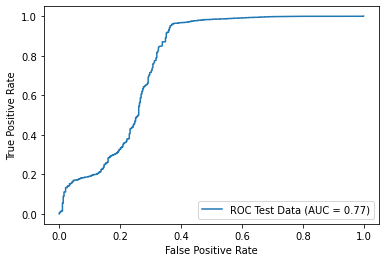

In [77]:
from sklearn import svm

def svm_model(training_unlabelled, training_labels, test_unlabelled, test_labels):
    print('SVM class_weight=None, C=10, gamma=0.1, kernel="rbf"')
    model = svm.SVC(class_weight=None, C=10, gamma=0.1, kernel="rbf")
    print("Training model")
    model.fit(training_unlabelled, training_labels)
    print("Trained model")
    print()
    
    print("Predicting")
    predictions = model.predict(test_unlabelled)
    print("Predicted")
    print()
    
    train_score = model.score(training_unlabelled, training_labels)
    test_score = model.score(test_unlabelled, test_labels)
    overfit = train_score - test_score
    
    print("Train Score", train_score)
    print("Test Score", test_score)
    print("Overfit", overfit)
    print()
    
    model_metrics(test_labels, predictions)
    plot_roc_curve(model, test_unlabelled, test_labels, name="ROC Test Data")
    plt.show()

svm_model(ss_training_unlabelled, training_labels, ss_test_unlabelled, test_labels)

The next model I try is a Random Forest. Again, this is preconfigured with the parameters found by the grid search.

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Took ~3 minutes on an i7-9700K@4.7GHz with 8 concurrent threads
def rf_cross_validation_grid_search(training_unlabelled, training_labels):
    cv_params = {
        "max_depth": [20, 50, 100, 120, 150],
        "max_features": ["auto", "log2", None],
        "n_estimators": [100, 200, 300],
        "class_weight": ["balanced", "auto"]
    }
    
    gs = GridSearchCV(RandomForestClassifier(), cv_params, refit=True, verbose=2, n_jobs=-1, scoring=make_scorer(matthews_corrcoef))
    gs_result = gs.fit(ss_training_unlabelled, training_labels)
    
    print("Best Estimator")
    print(gs_result.best_estimator_)
    print()
    
    print("Best Score")
    print(gs_result.best_score_)
    print()
    
    print("Best Params")
    print(gs_result.best_params_)
    print()

rf_cross_validation_grid_search(ss_training_unlabelled, training_labels)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.9min finished


Best Estimator
RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=None)

Best Score
0.4523795770487923

Best Params
{'class_weight': 'balanced', 'max_depth': 20, 'max_features': None, 'n_estimators': 100}



Now I train the model with the parameters found by the grid search. The results will differ to the report since the subsets used for the training of the decision trees are determined randomly.

RF class_weight='balanced', max_depth=20, max_features=None, n_estimators=100
Training model
Trained model

Predicting
Predicted

Train Score 0.9647562018819504
Test Score 0.9451152579582875
Overfit 0.01964094392366289

Test Samples 10021
True Positives 9251
False Positives 167
True Negatives 220
False Negatives 383

Recall 0.9602449657463151
Precision 0.9822679974516882
MCC 0.42839745934412055
BAS 0.5287204179426976
F1 0.9711316397228636

True Positive Rate (Sens / Recall) 0.9602449657463151
False Positive Rate (Spec) 0.4315245478036176
Positive Predictive Value (PPV / Precision) 0.9822679974516882
Negative Predictive Value (NPV) 0.3648424543946932
True Negative Rate 0.5684754521963824
False Negative Rate 0.039755034253684866
False Discovery Rate 0.017732002548311743

BER 0.23563979102865124
Utility 0.7643602089713488



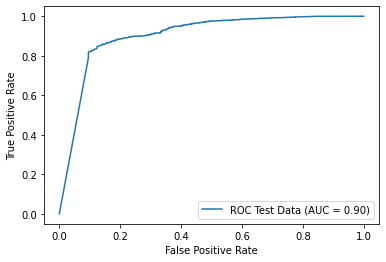

In [79]:
from sklearn.ensemble import RandomForestClassifier

def rf_model(training_unlabelled, training_labels, test_unlabelled, test_labels):
    print("RF class_weight='balanced', max_depth=20, max_features=None, n_estimators=100")
    model = RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=None, n_estimators=100)
    print("Training model")
    model.fit(training_unlabelled, training_labels)
    print("Trained model")
    print()
    
    print("Predicting")
    predictions = model.predict(test_unlabelled)
    print("Predicted")
    print()
    
    train_score = model.score(training_unlabelled, training_labels)
    test_score = model.score(test_unlabelled, test_labels)
    overfit = train_score - test_score
    
    print("Train Score", train_score)
    print("Test Score", test_score)
    print("Overfit", overfit)
    print()
    
    model_metrics(test_labels, predictions)
    plot_roc_curve(model, test_unlabelled, test_labels, name="ROC Test Data")
    plt.show()

rf_model(ss_training_unlabelled, training_labels, ss_test_unlabelled, test_labels)

Naive Bayes - no hyperparameters so no need to tune. This model performs poorly with scaled data so this one uses the unscaled data.

Naive Bayes: Gaussian
Training model
Trained model

Predicting
Predicted

Train Score 0.8529940119760479
Test Score 0.8498153876858597
Overfit 0.0031786242901881145

Test Samples 10021
True Positives 8186
False Positives 57
True Negatives 330
False Negatives 1448

Recall 0.8496989827693585
Precision 0.9930850418536941
MCC 0.3542764606661291
BAS 0.7024121610639322
F1 0.9158136152598312

True Positive Rate (Sens / Recall) 0.8496989827693585
False Positive Rate (Spec) 0.14728682170542637
Positive Predictive Value (PPV / Precision) 0.9930850418536941
Negative Predictive Value (NPV) 0.1856017997750281
True Negative Rate 0.8527131782945736
False Negative Rate 0.1503010172306415
False Discovery Rate 0.006914958146305957

BER 0.14879391946803394
Utility 0.8512060805319661



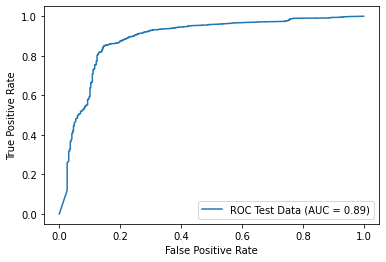

In [80]:
from sklearn.naive_bayes import GaussianNB

# Performs really poorly with scaled data
def nb_model(training_unlabelled, training_labels, test_unlabelled, test_labels):
    print("Naive Bayes: Gaussian")
    model = GaussianNB()
    print("Training model")
    model.fit(training_unlabelled, training_labels)
    print("Trained model")
    print()
    
    print("Predicting")
    predictions = model.predict(test_unlabelled)
    print("Predicted")
    print()
    
    train_score = model.score(training_unlabelled, training_labels)
    test_score = model.score(test_unlabelled, test_labels)
    overfit = train_score - test_score
    
    print("Train Score", train_score)
    print("Test Score", test_score)
    print("Overfit", overfit)
    print()
    
    model_metrics(test_labels, predictions)
    plot_roc_curve(model, test_unlabelled, test_labels, name="ROC Test Data")
    plt.show()

nb_model(training_unlabelled, training_labels, test_unlabelled, test_labels)

Next, I experiment with Logistic Regression.

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def lr_cross_validation_grid_search(training_unlabelled, training_labels):
    cv_params = {
        "C": [0.01, 0.1, 1, 10, 20],
        "penalty": ["l1", "l2"],
        "max_iter": [100, 200, 300, 400, 500],
        "class_weight": ["auto", "balanced"]
    }
    
    gs = GridSearchCV(LogisticRegression(class_weight="balanced"), cv_params, refit=True, verbose=2, n_jobs=-1, scoring=make_scorer(matthews_corrcoef))
    gs_result = gs.fit(training_unlabelled, training_labels)
    
    print("Best Estimator")
    print(gs_result.best_estimator_)
    print()
    
    print("Best Score")
    print(gs_result.best_score_)
    print()
    
    print("Best Params")
    print(gs_result.best_params_)
    print()

lr_cross_validation_grid_search(ss_training_unlabelled, training_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.7s finished


Best Estimator
LogisticRegression(C=10, class_weight='auto', max_iter=200)

Best Score
0.4673204984581189

Best Params
{'C': 10, 'class_weight': 'auto', 'max_iter': 200, 'penalty': 'l2'}



C:\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


I use the parameters determined by the grid search here.

LR C=10, class_weight="auto", max_iter=unlimited, penalty="l2"
Training model
Trained model

Predicting
Predicted

Train Score 0.9690333618477331
Test Score 0.9689651731364135
Overfit 6.818871131963888e-05

Test Samples 10021
True Positives 9586
False Positives 263
True Negatives 124
False Negatives 48

Recall 0.9950176458376583
Precision 0.9732967813991268
MCC 0.46795382094200744
BAS 0.3154310825301647
F1 0.984037365908741

True Positive Rate (Sens / Recall) 0.9950176458376583
False Positive Rate (Spec) 0.6795865633074936
Positive Predictive Value (PPV / Precision) 0.9732967813991268
Negative Predictive Value (NPV) 0.7209302325581395
True Negative Rate 0.32041343669250644
False Negative Rate 0.0049823541623417065
False Discovery Rate 0.026703218600873185

BER 0.34228445873491764
Utility 0.6577155412650824



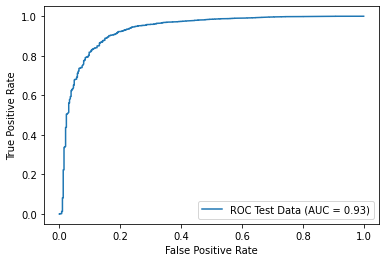

In [82]:
from sklearn.linear_model import LogisticRegression

def lr_model(training_unlabelled, training_labels, test_unlabelled, test_labels):
    print('LR C=10, class_weight="auto", max_iter=unlimited, penalty="l2"')
    model = LogisticRegression(C=10, class_weight="auto", max_iter = 100000, penalty="l2")
    print("Training model")
    model.fit(training_unlabelled, training_labels)
    print("Trained model")
    print()
    
    print("Predicting")
    predictions = model.predict(test_unlabelled)
    print("Predicted")
    print()
    
    train_score = model.score(training_unlabelled, training_labels)
    test_score = model.score(test_unlabelled, test_labels)
    overfit = train_score - test_score
    
    print("Train Score", train_score)
    print("Test Score", test_score)
    print("Overfit", overfit)
    print()
    
    model_metrics(test_labels, predictions)
    plot_roc_curve(model, test_unlabelled, test_labels, name="ROC Test Data")
    plt.show()

lr_model(ss_training_unlabelled, training_labels, ss_test_unlabelled, test_labels)

Here I use a MLP Neural Network Classifier

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Takes ~42 minutes
def nn_cross_validation_grid_search(training_unlabelled, training_labels):
    cv_params = {
        'hidden_layer_sizes': [(5, 2), (50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam', 'lbfgs'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
        "max_iter": [100, 200, 300]
    }
    
    gs = GridSearchCV(MLPClassifier(), cv_params, refit=True, verbose=2, n_jobs=-1, scoring=make_scorer(matthews_corrcoef))
    gs_result = gs.fit(training_unlabelled, training_labels)
    
    print("Best Estimator")
    print(gs_result.best_estimator_)
    print()
    
    print("Best Score")
    print(gs_result.best_score_)
    print()
    
    print("Best Params")
    print(gs_result.best_params_)
    print()

nn_cross_validation_grid_search(ss_training_unlabelled, training_labels)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 39.9min finished


Best Estimator
MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50),
              learning_rate='adaptive', max_iter=100)

Best Score
0.5168725571559672

Best Params
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'adam'}



MLPClassifier; activation='relu', alpha=0.05, hidden_layer_sizes=(100,), solver='adam', learning_rate='adaptive', max_iter=300
Training model
Trained model

Predicting
Predicted

Train Score 0.9716852010265183
Test Score 0.971160562818082
Overfit 0.0005246382084362899

Test Samples 10021
True Positives 9589
False Positives 244
True Negatives 143
False Negatives 45

Recall 0.9953290429728047
Precision 0.9751855995118479
MCC 0.5181279600805989
BAS 0.3648380869004533
F1 0.9851543637951404

True Positive Rate (Sens / Recall) 0.9953290429728047
False Positive Rate (Spec) 0.6304909560723514
Positive Predictive Value (PPV / Precision) 0.9751855995118479
Negative Predictive Value (NPV) 0.7606382978723404
True Negative Rate 0.3695090439276486
False Negative Rate 0.00467095702719535
False Discovery Rate 0.02481440048815214

BER 0.31758095654977336
Utility 0.6824190434502266



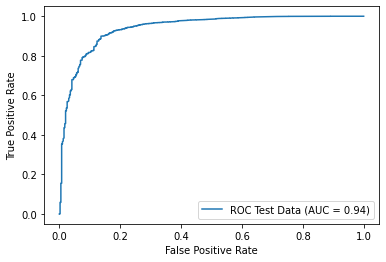

In [84]:
from sklearn.neural_network import MLPClassifier

def nn_model(training_unlabelled, training_labels, test_unlabelled, test_labels):
    print("MLPClassifier; activation='relu', alpha=0.05, hidden_layer_sizes=(100,), solver='adam', learning_rate='adaptive', max_iter=300")
    model = MLPClassifier(activation='relu', alpha=0.05, hidden_layer_sizes=(100,), solver='adam', learning_rate='adaptive', max_iter=300)
    print("Training model")
    model.fit(training_unlabelled, training_labels)
    print("Trained model")
    print()
    
    print("Predicting")
    predictions = model.predict(test_unlabelled)
    print("Predicted")
    print()
    
    train_score = model.score(training_unlabelled, training_labels)
    test_score = model.score(test_unlabelled, test_labels)
    overfit = train_score - test_score
    
    print("Train Score", train_score)
    print("Test Score", test_score)
    print("Overfit", overfit)
    print()
    
    model_metrics(test_labels, predictions)
    plot_roc_curve(model, test_unlabelled, test_labels, name="ROC Test Data")
    plt.show()

nn_model(ss_training_unlabelled, training_labels, ss_test_unlabelled, test_labels)

Voting Classifier - Ensemble of that I have used already.

In [85]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm

def vc_model(training_unlabelled, training_labels, test_unlabelled, test_labels):
    print("VotingClassifier; NN, RF, LR, SVM using previously determined hyperparameters")
    
    nn_model = MLPClassifier(activation='relu', alpha=0.05, hidden_layer_sizes=(100,), solver='adam', learning_rate='adaptive', max_iter=300)
    rf_model = RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=None, n_estimators=100)
    lr_model = LogisticRegression(C=10, class_weight="auto", max_iter = 100000, penalty="l2")
    sv_model = svm.SVC(class_weight=None, C=10, gamma=0.1, kernel="rbf")
    
    model = VotingClassifier(estimators=[
        ("nn", nn_model), ("rf", rf_model), ("lr", lr_model), ("sv", sv_model)
    ])
    print("Training model")
    
    model.fit(training_unlabelled, training_labels)
    print("Trained model")
    print()
    
    print("Predicting")
    predictions = model.predict(test_unlabelled)
    print("Predicted")
    print()
    
    train_score = model.score(training_unlabelled, training_labels)
    test_score = model.score(test_unlabelled, test_labels)
    overfit = train_score - test_score
    
    print("Train Score", train_score)
    print("Test Score", test_score)
    print("Overfit", overfit)
    print()
    
    model_metrics(test_labels, predictions)

vc_model(training_unlabelled, training_labels, test_unlabelled, test_labels)

VotingClassifier; NN, RF, LR, SVM using previously determined hyperparameters
Training model
Trained model

Predicting
Predicted

Train Score 0.9790846877673225
Test Score 0.9699630775371719
Overfit 0.009121610230150567

Test Samples 10021
True Positives 9612
False Positives 279
True Negatives 108
False Negatives 22

Recall 0.9977164210089268
Precision 0.9717925386715196
MCC 0.4713151951293579
BAS 0.2767861884507872
F1 0.984583866837388

True Positive Rate (Sens / Recall) 0.9977164210089268
False Positive Rate (Spec) 0.7209302325581395
Positive Predictive Value (PPV / Precision) 0.9717925386715196
Negative Predictive Value (NPV) 0.8307692307692308
True Negative Rate 0.27906976744186046
False Negative Rate 0.002283578991073282
False Discovery Rate 0.028207461328480437

BER 0.36160690577460636
Utility 0.6383930942253937

